1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

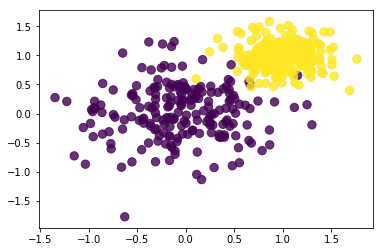

In [1]:
from IPython.display import Image
Image('two_categories_scatter_plot.png')

<ipython-input-43-6a4598119a90>:6: RuntimeWarning: covariance is not positive-semidefinite.
  x = np.random.multivariate_normal(means[1], covs[1], size=50)
<ipython-input-43-6a4598119a90>:7: RuntimeWarning: covariance is not positive-semidefinite.
  y = np.random.multivariate_normal(means[0], covs[0], size=50)
<ipython-input-43-6a4598119a90>:11: RuntimeWarning: covariance is not positive-semidefinite.
  x = np.random.multivariate_normal(means[0], covs[0], size=50)
<ipython-input-43-6a4598119a90>:12: RuntimeWarning: covariance is not positive-semidefinite.
  y = np.random.multivariate_normal(means[1], covs[1], size=50)


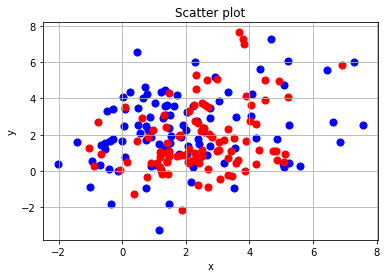

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
means = np.array([[2, 3], [1, 3]])
covs = np.array([[[3, 2],[1, 3]], [[2, 5], [1, 3]]])
x = np.random.multivariate_normal(means[1], covs[1], size=50)
y = np.random.multivariate_normal(means[0], covs[0], size=50)

plt.scatter(x[:], y[:], s=50, c='blue')

x = np.random.multivariate_normal(means[0], covs[0], size=50)
y = np.random.multivariate_normal(means[1], covs[1], size=50)

plt.scatter(x[:], y[:], s=50, c='red')
plt.title(f"Scatter plot")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()

2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [50]:
import pickle
import pandas as pd
df = pd.read_pickle('./data/residuals_261.pkl')
infile = open('./data/residuals_261.pkl', 'rb')
new_dict = pickle.load(infile)
infile.close()



array({'residuals': array([ 1.1       , -1.95      , -7.2       , ...,  0.08333333,
        0.16666667,  0.08333333]), 'distances': array([16. ,  6.3,  3.4, ...,  1.7, 19.1,  2.6])},
      dtype=object)

3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


(array([ 4.,  6.,  2.,  3.,  2.,  1.,  5.,  3.,  4.,  3.,  3.,  1.,  5.,
         3.,  3.,  1.,  6.,  9., 16., 20.]),
 array([0.00916638, 0.02865391, 0.04814144, 0.06762896, 0.08711649,
        0.10660402, 0.12609155, 0.14557908, 0.1650666 , 0.18455413,
        0.20404166, 0.22352919, 0.24301672, 0.26250425, 0.28199177,
        0.3014793 , 0.32096683, 0.34045436, 0.35994189, 0.37942941,
        0.39891694]),
 <BarContainer object of 20 artists>)

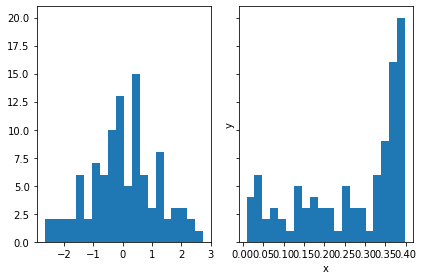

In [93]:
from scipy.stats import norm
import scipy
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
x = np.array(norm.rvs(size=100,loc=0,scale=1))
x_o = norm.pdf(x)
suma = np.sum(x_o)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
plt.xlabel("x")
plt.ylabel("y")
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[0].hist(x, bins=20)
axs[1].hist(x_o, bins=20)